In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Augmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os

# Define augmentation pipeline
augmentation = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"])
)

# Function to read YOLO format bounding boxes
def read_yolo_labels(label_path):
    bboxes = []
    class_ids = []
    with open(label_path, "r") as file:
        for line in file.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            bboxes.append(bbox)
            class_ids.append(class_id)
    return bboxes, class_ids

# Function to save YOLO format bounding boxes
def save_yolo_labels(label_path, bboxes, class_ids):
    with open(label_path, "w") as file:
        for class_id, bbox in zip(class_ids, bboxes):
            bbox_str = " ".join(map(str, bbox))
            file.write(f"{class_id} {bbox_str}\n")

# Function to augment an image and its bounding boxes
def augment_image(image_path, bboxes, class_labels):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    augmented = augmentation(image=image, bboxes=bboxes, class_labels=class_labels)
    return augmented["image"], augmented["bboxes"], augmented["class_labels"]

# Define dataset paths
dataset_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/train/images"
labels_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/train/labels"
augmented_dataset_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset"

# Create directories for augmented dataset
os.makedirs(f"{augmented_dataset_path}/images", exist_ok=True)
os.makedirs(f"{augmented_dataset_path}/labels", exist_ok=True)

# Loop through all images and labels
for img_file in os.listdir(dataset_path):
    if img_file.endswith(".bmp"):  # Adjust for your image file extension
        img_path = os.path.join(dataset_path, img_file)
        label_path = os.path.join(labels_path, img_file.replace(".bmp", ".txt"))

        # Check if label file exists
        if not os.path.exists(label_path):
            print(f"Label file not found for image: {img_path}. Skipping.")
            continue

        # Read bounding boxes and class labels
        bboxes, class_labels = read_yolo_labels(label_path)

        # Apply augmentations
        try:
            augmented_image, augmented_bboxes, augmented_class_labels = augment_image(
                img_path, bboxes, class_labels
            )
        except Exception as e:
            print(f"Error augmenting image {img_file}: {e}")
            continue

        # Save augmented image
        augmented_img_path = f"{augmented_dataset_path}/images/aug_{img_file}"
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)  # Convert back to BGR
        cv2.imwrite(augmented_img_path, augmented_image)

        # Save augmented labels
        augmented_label_path = f"{augmented_dataset_path}/labels/aug_{img_file.replace('.bmp', '.txt')}"
        save_yolo_labels(augmented_label_path, augmented_bboxes, augmented_class_labels)

        print(f"Augmented image and labels saved: {augmented_img_path}, {augmented_label_path}")


/usr/local/lib/python3.10/dist-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


Augmented image and labels saved: /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/images/aug_108.bmp, /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/labels/aug_108.txt
Augmented image and labels saved: /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/images/aug_414.bmp, /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/labels/aug_414.txt
Augmented image and labels saved: /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/images/aug_355.bmp, /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/labels/aug_355.txt
Augmented image and labels saved: /content/drive/MyDrive/Zebra Editable Label Generat

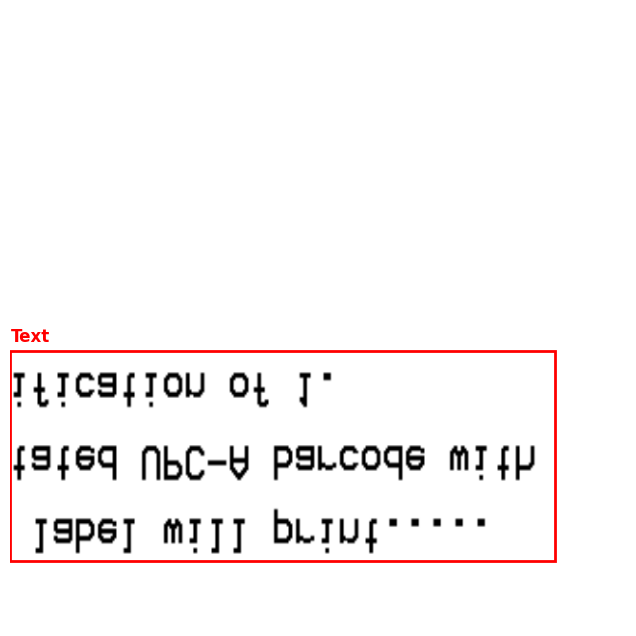

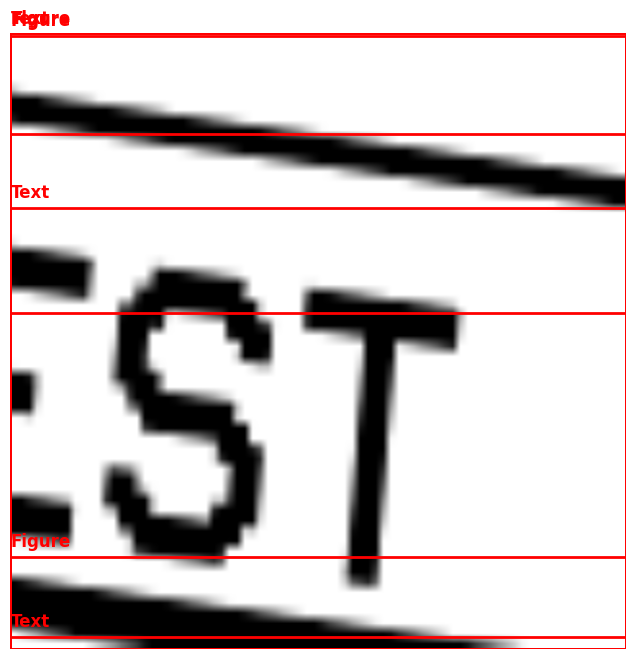

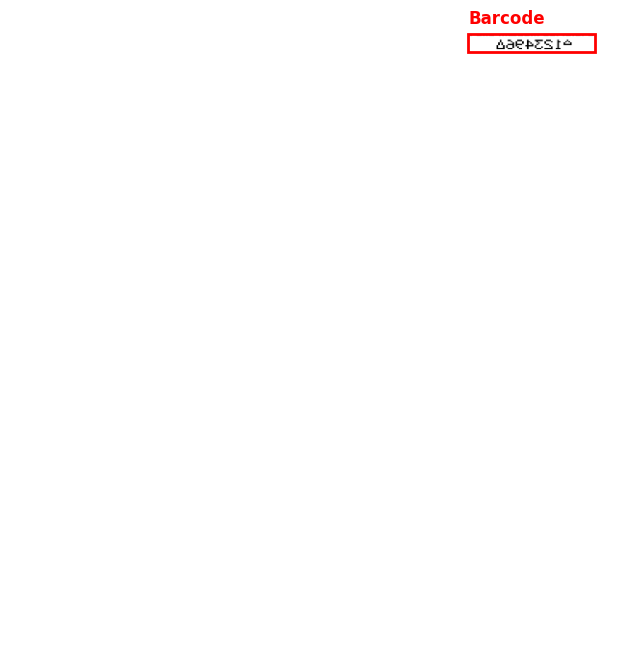

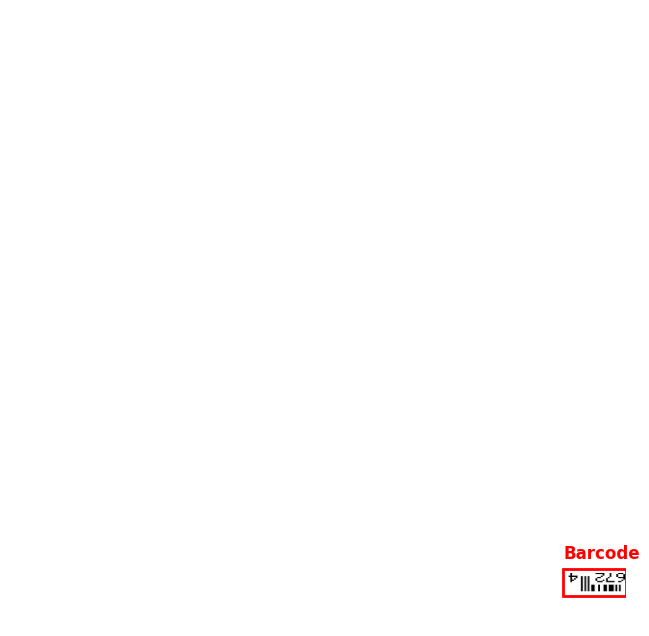

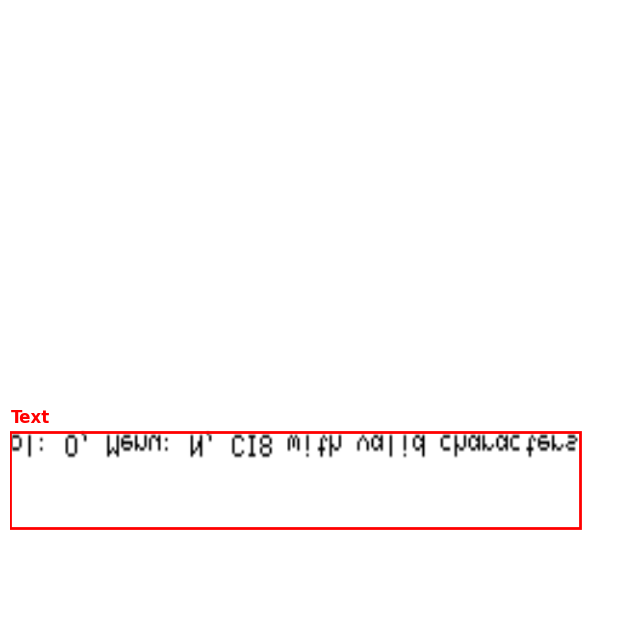

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths to the augmented dataset
augmented_images_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/images"
augmented_labels_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/labels"

# Function to display an image with bounding boxes
def display_image_with_bboxes(image_path, label_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load the bounding boxes
    with open(label_path, 'r') as f:
        annotations = [line.strip().split() for line in f.readlines()]

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for ann in annotations:
        class_id, x_center, y_center, width, height = map(float, ann)
        x_min = (x_center - width / 2) * image.shape[1]
        y_min = (y_center - height / 2) * image.shape[0]
        box_width = width * image.shape[1]
        box_height = height * image.shape[0]

        # Draw bounding box
        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add class label
        class_names = ['Text', 'Barcode', 'Figure']
        ax.text(x_min, y_min - 10, class_names[int(class_id)], color='red', fontsize=12, weight='bold')

    plt.axis("off")
    plt.show()

# Visualize a few augmented images
for img_file in os.listdir(augmented_images_path)[:5]:  # Change the number to see more or fewer images
    if img_file.endswith(".bmp"):  # Adjust extension if needed
        img_path = os.path.join(augmented_images_path, img_file)
        label_path = os.path.join(augmented_labels_path, img_file.replace(".bmp", ".txt"))

        if os.path.exists(label_path):
            display_image_with_bboxes(img_path, label_path)
        else:
            print(f"No label file found for {img_file}")


## Combine Augmented Data with Original Data


In [ ]:
import shutil
import os

# Paths
augmented_images_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/images"
augmented_labels_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/augmented/dataset/labels"
train_images_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/train/images"
train_labels_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/train/labels"

# Move augmented images to training folder
for file_name in os.listdir(augmented_images_path):
    shutil.move(os.path.join(augmented_images_path, file_name), train_images_path)

# Move augmented labels to training folder
for file_name in os.listdir(augmented_labels_path):
    shutil.move(os.path.join(augmented_labels_path, file_name), train_labels_path)

print("Augmented images and labels moved to training folder.")


Augmented images and labels moved to training folder.


In [ ]:
# Clone YOLOv5 repo and navigate to it
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install required dependencies
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17059, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17059 (delta 18), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17059/17059), 15.68 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (11713/11713), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 20.5 MB/s eta 0:00:00


## Training model on train data that combined original train data and augmented data

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/data.yaml" --weights yolov5s.pt --project "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO" --name exp_augmented


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-19 19:43:46.022605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 19:43:46.054889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 19:43:46.065339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [ ]:
!python train.py \
--img 640 \
--batch 16 \
--epochs 50 \
--data "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/data.yaml" \
--weights yolov5s.pt \
--project "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO" \
--name exp_augmented_final


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-19 20:45:30.678727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 20:45:30.711510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 20:45:30.721768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

In [ ]:
!python detect.py \
--weights "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_augmented_final/weights/best.pt" \
--source "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/images" \
--conf-thres 0.1 \
--save-txt \
--save-conf \
--project "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO" \
--name val_predictions


detect: weights=['/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_augmented_final/weights/best.pt'], source=/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO, name=val_predictions, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-385-gb968b2d7 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/60 /content/drive/MyDrive/Zebra Edita

## Evaluating on Validation Dataset

In [ ]:
import os

# Paths to ground truth and predicted labels directories
ground_truth_labels_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/labels"
predicted_labels_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/labels"

# Initialize lists to keep track of missing or extra files
missing_predictions = []
extra_predictions = []

# Get all ground truth and predicted label files
ground_truth_files = [f for f in os.listdir(ground_truth_labels_dir) if f.endswith(".txt") and f not in [".DS_Store", "classes.txt"]]
predicted_files = [f for f in os.listdir(predicted_labels_dir) if f.endswith(".txt")]

# Check for missing prediction files
for gt_file in ground_truth_files:
    if gt_file not in predicted_files:
        missing_predictions.append(gt_file)

# Check for extra prediction files that do not correspond to ground truth
for pred_file in predicted_files:
    if pred_file not in ground_truth_files:
        extra_predictions.append(pred_file)

# Print the results
if missing_predictions:
    print(f"Missing prediction files for the following ground truth files:")
    for file in missing_predictions:
        print(file)
else:
    print("All ground truth files have corresponding predictions.")

if extra_predictions:
    print(f"\nExtra prediction files found (no corresponding ground truth):")
    for file in extra_predictions:
        print(file)
else:
    print("\nNo extra prediction files found.")


Missing prediction files for the following ground truth files:
607.txt
609.txt

No extra prediction files found.


Error processing file /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/labels/.DS_Store: invalid literal for int() with base 10: '\x00\x00\x00\x01Bud1\x00\x00\x10\x00\x00\x00\x08\x00\x00\x00\x10\x00\x00\x00\x00%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x08\x00\x00\x
Excluding 607.txt from evaluation.
Excluding 609.txt from evaluation.
Error processing file /content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/labels/classes.txt: invalid literal for int() with base 10: 'text'
No missing prediction files.
No extra prediction files.
Precision per class: [0.43925234 0.39310345 0.1875    ]
Recall per class: [0.46078431 0.52777778 0.08108108]
F1 Score per class: [0.44976077 0.45059289 0.11320755]

Classification Report:
               precision    recall  f1-score   support

        Text       0.44      0.46      0.45       102
  

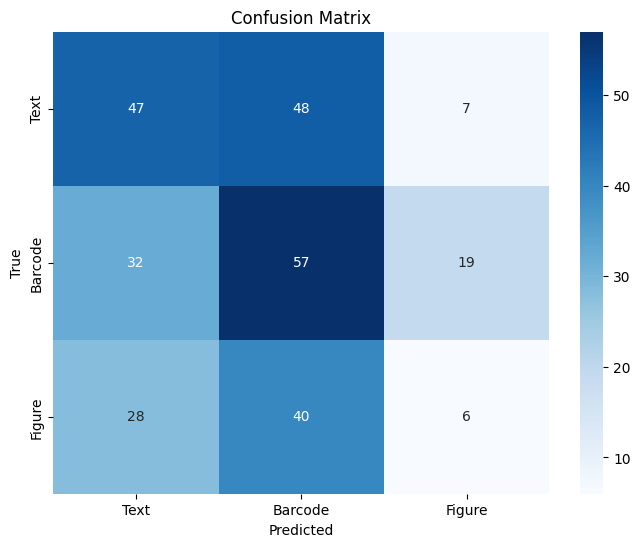

Confusion matrix saved to /content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/confusion_matrix.png


In [ ]:
import os
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
predicted_labels_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/labels"
ground_truth_labels_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/labels"

# Classes (as per your data.yaml file)
class_names = ["Text", "Barcode", "Figure"]

# Files to exclude
exclude_files = ["607.txt", "609.txt"]

# Initialize ground truth and predictions
y_true = []
y_pred = []

# Track missing or extra files
missing_predictions = []
extra_predictions = []

# Check ground truth files
for gt_file in os.listdir(ground_truth_labels_dir):
    # Skip excluded files
    if gt_file in exclude_files:
        print(f"Excluding {gt_file} from evaluation.")
        continue

    gt_path = os.path.join(ground_truth_labels_dir, gt_file)
    pred_path = os.path.join(predicted_labels_dir, gt_file)

    try:
        # Load ground truth labels
        with open(gt_path, 'r', errors='ignore') as f:
            ground_truth = [line.strip().split() for line in f.readlines()]
            gt_classes = [int(x[0]) for x in ground_truth]

        # Check if prediction exists
        if os.path.exists(pred_path):
            with open(pred_path, 'r', errors='ignore') as f:
                predictions = [line.strip().split() for line in f.readlines()]
                pred_classes = [int(x[0]) for x in predictions]
        else:
            pred_classes = []
            missing_predictions.append(gt_file)

        # Add ground truth and predictions for each object
        y_true.extend(gt_classes)
        y_pred.extend(pred_classes)

    except Exception as e:
        print(f"Error processing file {gt_path}: {e}")
        continue

# Check for extra prediction files
for pred_file in os.listdir(predicted_labels_dir):
    if pred_file not in os.listdir(ground_truth_labels_dir):
        extra_predictions.append(pred_file)

# Report missing or extra files
if missing_predictions:
    print("Missing prediction files for the following ground truth files:")
    print(missing_predictions)
else:
    print("No missing prediction files.")

if extra_predictions:
    print("Extra prediction files found:")
    print(extra_predictions)
else:
    print("No extra prediction files.")

# Handle cases where no predictions exist
if len(y_pred) == 0:
    y_pred = [len(class_names)] * len(y_true)  # Assign "unknown" class if no predictions

# Ensure alignment of y_true and y_pred
min_length = min(len(y_true), len(y_pred))
y_true = y_true[:min_length]
y_pred = y_pred[:min_length]

# Compute metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)))
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Generate a detailed classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=2)

# Print metrics
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1_score)
print("\nClassification Report:\n", report)

# Save metrics to a file (optional)
metrics_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/metrics_report.txt"
with open(metrics_path, "w") as f:
    f.write("Classification Report:\n")
    f.write(report)
print(f"Metrics report saved to {metrics_path}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

conf_matrix_path = "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.show()

print(f"Confusion matrix saved to {conf_matrix_path}")


## Visualize Predictions

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Paths
image_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/images"
predicted_labels_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/labels"
ground_truth_labels_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/labels"
output_visualization_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/visualizations"
os.makedirs(output_visualization_dir, exist_ok=True)

# Classes (as per your data.yaml file)
class_names = ["Text", "Barcode", "Figure"]

# Updated function to handle extra values in bounding box
def read_yolo_labels(label_path):
    bboxes = []
    class_ids = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])  # First value is the class ID
            bbox = list(map(float, parts[1:5]))  # Next 4 values are the bounding box (ignore extra values)
            bboxes.append(bbox)
            class_ids.append(class_id)
    return bboxes, class_ids


# Function to draw bounding boxes on an image
def draw_bboxes(image, bboxes, class_ids, class_names, color):
    h, w, _ = image.shape
    for bbox, class_id in zip(bboxes, class_ids):
        x_center, y_center, width, height = bbox
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        label = class_names[class_id]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image

# Visualize each image
for img_file in os.listdir(image_dir):
    if img_file.endswith(".bmp"):  # Adjust extension if necessary
        img_path = os.path.join(image_dir, img_file)
        gt_label_path = os.path.join(ground_truth_labels_dir, img_file.replace(".bmp", ".txt"))
        pred_label_path = os.path.join(predicted_labels_dir, img_file.replace(".bmp", ".txt"))

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error loading image: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load ground truth and predictions
        if os.path.exists(gt_label_path):
            gt_bboxes, gt_class_ids = read_yolo_labels(gt_label_path)
            image = draw_bboxes(image, gt_bboxes, gt_class_ids, class_names, (0, 255, 0))  # Green for ground truth
        if os.path.exists(pred_label_path):
            pred_bboxes, pred_class_ids = read_yolo_labels(pred_label_path)
            image = draw_bboxes(image, pred_bboxes, pred_class_ids, class_names, (255, 0, 0))  # Red for predictions

        # Save visualized image
        output_path = os.path.join(output_visualization_dir, img_file)
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")
        output_path = output_path.replace('.bmp', '.png')
        plt.savefig(output_path)
        plt.close()

print(f"Visualizations saved to: {output_visualization_dir}")


Visualizations saved to: /content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/visualizations


## Compare Models Performance

## Testing Augmented Model on Test Data

In [ ]:
!python detect.py \
    --weights "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_augmented_final/weights/best.pt" \
    --source "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/test/Images" \
    --save-txt \
    --save-conf \
    --project "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO" \
    --name test_predictions_augmented


detect: weights=['/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_augmented_final/weights/best.pt'], source=/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/test/Images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO, name=test_predictions_augmented, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-385-gb968b2d7 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/60 /content/drive/MyDriv

## Running older models on test data

In [ ]:
!python detect.py \
    --weights "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/weights/best.pt" \
    --source "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/test/Images" \
    --save-txt \
    --save-conf \
    --project "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO" \
    --name test_predictions_hybrid_loss


detect: weights=['/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/exp_hybrid_loss/weights/best.pt'], source=/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/test/Images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO, name=test_predictions_hybrid_loss, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-386-g81ac034a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/60 /content/drive/MyDrive/

## Results

In [2]:
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Arguments:
    box1, box2 -- [x_center, y_center, width, height] in YOLO format (normalized to [0,1]).

    Returns:
    iou -- Intersection over Union (IoU) value.
    """
    # Convert from YOLO format to corner coordinates
    x1_min, y1_min = box1[0] - box1[2] / 2, box1[1] - box1[3] / 2
    x1_max, y1_max = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
    x2_min, y2_min = box2[0] - box2[2] / 2, box2[1] - box2[3] / 2
    x2_max, y2_max = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

    # Calculate intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Calculate intersection area
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Calculate union area
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou


In [3]:
import os

# Paths to validation ground truth and predicted labels
ground_truth_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/YOLO/val_predictions2/labels"
predicted_labels_dir = "/content/drive/MyDrive/Zebra Editable Label Generation Project/Data/ZPL Project/Data_subset_Final/val/labels"

# Initialize IoU list
iou_values = []

for gt_file in os.listdir(ground_truth_dir):
    gt_path = os.path.join(ground_truth_dir, gt_file)
    pred_path = os.path.join(predicted_labels_dir, gt_file)

    # Read ground truth boxes
    with open(gt_path, 'r') as f:
        ground_truth_boxes = [list(map(float, line.strip().split()[1:])) for line in f.readlines()]

    # Read predicted boxes
    if os.path.exists(pred_path):
        with open(pred_path, 'r') as f:
            predicted_boxes = [list(map(float, line.strip().split()[1:])) for line in f.readlines()]
    else:
        predicted_boxes = []

    # Match predicted boxes to ground truth (assumes one-to-one correspondence)
    for gt_box, pred_box in zip(ground_truth_boxes, predicted_boxes):
        iou = calculate_iou(gt_box, pred_box)
        iou_values.append(iou)


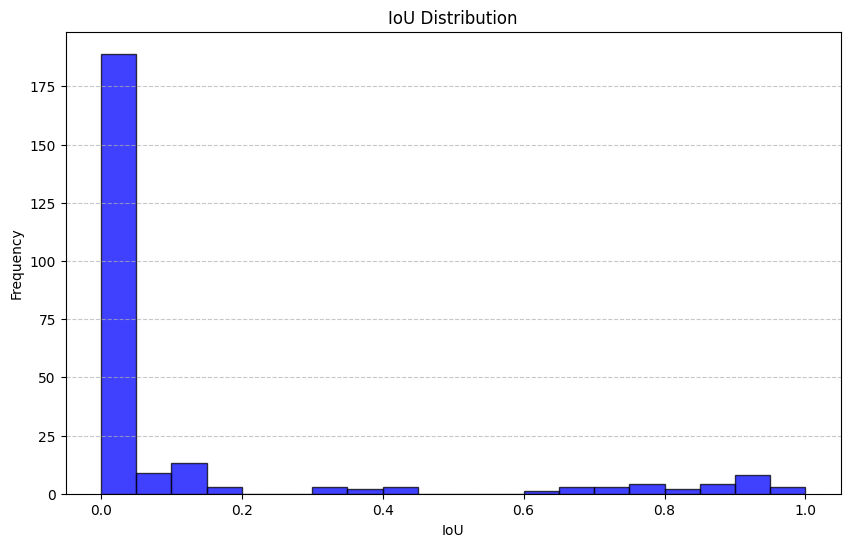

In [4]:
import matplotlib.pyplot as plt

# Plot IoU distribution
plt.figure(figsize=(10, 6))
plt.hist(iou_values, bins=20, range=(0, 1), alpha=0.75, color='blue', edgecolor='black')
plt.title("IoU Distribution")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [5]:
mean_iou = np.mean(iou_values)
print(f"Mean IoU: {mean_iou:.4f}")


Mean IoU: 0.1180
